# Problem Statement E [UCI News Aggregator]
# Group 27
1.   Joy Mukerjee - 2022DC04311
2.   Neha Mugloo  - 2022DC04504
3.   Swati Muley  - 2022DC04455


In [31]:
pip install pyLDAvis

In [32]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
from spacy import displacy
from collections import Counter
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation as LDA
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import random
import warnings

# Download NLTK resources if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Exploratory Data Analysis

Duplicate and Missing Checks, Outliers Removal, Title Length Distribution, and Visualization with Stop Words Removal. Overall, these steps ensure that the dataset is clean, representative, and free from unnecessary noise, improving the quality and accuracy of further analysis or modeling efforts.



**a. Dataset Overview**

In [33]:
# Load the dataset with appropriate encoding
df = pd.read_csv('/content/uci-news-aggregator.csv', encoding='latin1', on_bad_lines='skip')  # Skip problematic lines

# Sample 5000 rows from the dataset
df = df.sample(n=5000, random_state=42)  # Using random_state for reproducibility

# Basic dataset overview
print("### Dataset Overview ###")
print(f"Dataset Shape: {df.shape}")
print("Data Types:\n", df.dtypes)
print("Summary Statistics:\n", df.describe(include='all'))

# Checking unique values in categorical columns
print("\n### Unique Values ###")
print(f"Unique Publishers: {df['PUBLISHER'].nunique()}")
print(f"Unique Categories: {df['CATEGORY'].nunique()}")

# Most common publishers and categories
print("\n### Top Publishers and Categories ###")
print("Top Publishers:\n", df['PUBLISHER'].value_counts().head())
print("Top Categories:\n", df['CATEGORY'].value_counts().head())

### Dataset Overview ###
Dataset Shape: (5000, 8)
Data Types:
 ID             int64
TITLE         object
URL           object
PUBLISHER     object
CATEGORY      object
STORY         object
HOSTNAME      object
TIMESTAMP    float64
dtype: object
Summary Statistics:
                    ID              TITLE  \
count     5000.000000               5000   
unique            NaN               4995   
top               NaN  Daily FX Analysis   
freq              NaN                  3   
mean    211643.124600                NaN   
std     121746.858487                NaN   
min         82.000000                NaN   
25%     108738.750000                NaN   
50%     211893.000000                NaN   
75%     314602.500000                NaN   
max     422923.000000                NaN   

                                                      URL PUBLISHER CATEGORY  \
count                                                5000      5000     5000   
unique                                       

**a. Duplicate and Missing Checks:**

 During EDA, it is essential to check for duplicate entries and missing values in the dataset as they can introduce bias or reduce the quality of the analysis. Duplicates are removed to ensure the data doesn't contain redundant information, which could skew models or interpretations. Missing values can either be imputed or removed, depending on the severity and relevance to the task.

In [34]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"\n### Duplicate Rows ###\nNumber of Duplicate Rows: {duplicates}")

# Checking missing values
print("\n### Missing Values ###")
print(df.isnull().sum())


### Duplicate Rows ###
Number of Duplicate Rows: 0

### Missing Values ###
ID           0
TITLE        0
URL          0
PUBLISHER    0
CATEGORY     0
STORY        0
HOSTNAME     0
TIMESTAMP    0
dtype: int64


**c. Outlier Checks**

Outliers are extreme values that do not follow the general trend of the data and can negatively impact model performance by introducing noise. For continuous variables (like title length), identifying and removing these outliers helps in maintaining a clean dataset that is more representative of general patterns. Outliers are typically detected using statistical methods like IQR (Interquartile Range) or Z-scores, which can flag values far outside the normal distribution.

In [35]:
numerical_columns = df.select_dtypes(include=['number'])
numerical_columns
# Calculate z-scores for each numerical column
z_scores = (numerical_columns - numerical_columns.mean()) / numerical_columns.std()
z_scores
# Define threshold for identifying outliers (e.g., z-score > 3 or < -3)
threshold = 3

# Identify outliers based on z-scores
outliers = (z_scores > threshold) | (z_scores < -threshold)
# Print rows with outliers
print("Rows with outliers:")
df[outliers.any(axis=1)]

Rows with outliers:


,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP


**d. Title Length Distribution and Visualization**



Analyzing the distribution of title lengths provides insights into the structure of the data and can reveal underlying trends. The distribution is often visualized using histograms or box plots, which make it easier to identify patterns like skewness, peaks, and potential outliers in the data. The title length is a crucial feature for text-based models, and understanding its distribution is key to understanding the dataset's characteristics.


### Title Length Distribution ###
count    5000.000000
mean        9.107000
std         2.566567
min         1.000000
25%         7.000000
50%         9.000000
75%        11.000000
max        17.000000
Name: title_length, dtype: float64


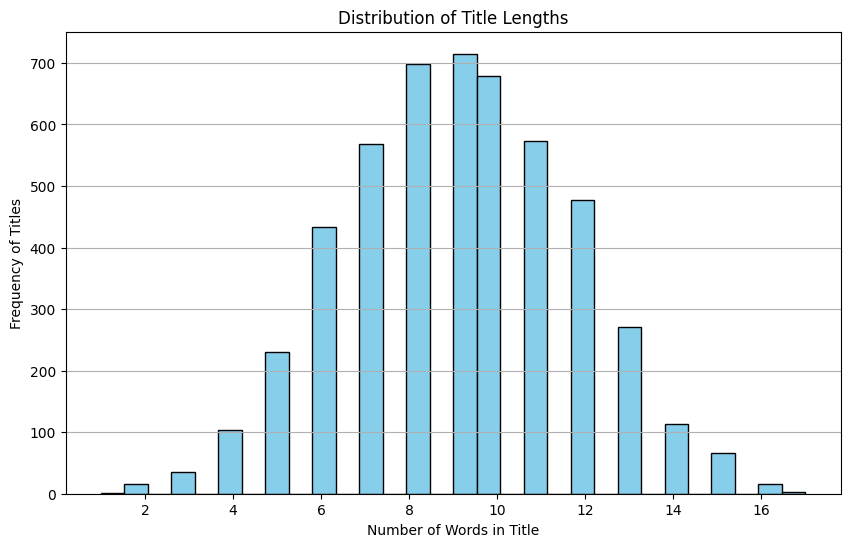

In [36]:
# Distribution of title lengths
print("\n### Title Length Distribution ###")
df['clean_title'] = df['TITLE'].str.lower().str.replace('[^\w\s]', '', regex=True)
df['title_length'] = df['clean_title'].apply(lambda x: len(x.split()))
print(df['title_length'].describe())

# Visualizing Title Lengths
plt.figure(figsize=(10, 6))
plt.hist(df['title_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Title Lengths')
plt.xlabel('Number of Words in Title')
plt.ylabel('Frequency of Titles')
plt.grid(axis='y')
plt.show()

**e. Stopwords removal**

Stop words are common words (like 'the', 'is', 'in') that do not carry significant meaning but occur frequently in text data. Removing stop words is a standard preprocessing step in text analysis, as it reduces noise in the data, improves model performance, and ensures that the focus is on more meaningful words. After stop words are removed, the remaining tokens are more representative of the actual content and context of the text.

In [37]:
# Get the stop words
stop_words = set(stopwords.words('english'))

# Function to remove stop words
def remove_stop_words(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply the function to the DataFrame
df['filtered_text'] = df['clean_title'].apply(remove_stop_words)

#print(df)
df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,clean_title,title_length,filtered_text
280241,280701,Only 2 people allowed in the delivery room: Pr...,http://indiatoday.intoday.in/story/only-2-peop...,India Today,e,dQEXtwpswiNW-4MJkBLcTFNZCQ42M,indiatoday.intoday.in,1.402690e+12,only 2 people allowed in the delivery room pre...,13,2 people allowed delivery room pregger mila ku...
96315,96509,"A wealth of info, a welter of questions",http://www.kspr.com/news/nationworld/A-wealth-...,KSPR,b,dEvmvYzvzgsQELMCi7irY9O3H-7MM,www.kspr.com,1.397230e+12,a wealth of info a welter of questions,8,wealth info welter questions
280410,280870,Robin Thicke Naming Album After Paula Pattonâ¦,http://hollywoodlife.com/2014/06/12/robin-thic...,Hollywood Life,e,dflCph2zJvu4FcMqqxixfobGH4qjM,hollywoodlife.com,1.402690e+12,robin thicke naming album after paula pattonâ,7,robin thicke naming album paula pattonâ
284975,285435,Actress And Civil Rights Activist Ruby Dee Die...,http://wegotthiscovered.com/movies/actress-civ...,We Got This Covered,e,duy-eYWM3GLFeSMlLjm7WEMy_7YJM,wegotthiscovered.com,1.402760e+12,actress and civil rights activist ruby dee die...,10,actress civil rights activist ruby dee dies 91
379072,379532,Feds to review Ga. Medicaid backlog,http://beta.mirror.augusta.com/news/government...,McDuffie Mirror,m,d_fPPa35mZtsqpM0o8GY7u6XaAydM,beta.mirror.augusta.com,1.405440e+12,feds to review ga medicaid backlog,6,feds review ga medicaid backlog


**f. Word Frequency Analysis and Common Words**

Word frequency analysis is a fundamental step in text analysis that helps identify the most commonly occurring words in the dataset. By joining all the preprocessed text data from the 'filtered_text' column, a single large string of words is created, which is then split into individual tokens. The Counter class from the collections module is used to count the frequency of each word. Displaying the most common words gives insights into the dominant terms in the dataset, revealing key themes or topics present in the text. This step is particularly useful for understanding the overall structure of the data and identifying any potential noise, such as frequently occurring irrelevant words.

In [38]:
# Word frequency analysis
all_words = ' '.join(df['filtered_text']).split()
word_freq = Counter(all_words)

# Display most common words
print("\n### Most Common Words ###")
print(word_freq.most_common(10))


### Most Common Words ###
[('new', 285), ('us', 226), ('google', 135), ('apple', 116), ('video', 108), ('samsung', 108), ('may', 102), ('2014', 102), ('first', 98), ('says', 97)]


**g. Word Cloud Visualization**

Word Cloud Visualization provides an intuitive and visually appealing way to represent word frequency within a dataset. In this case, the word cloud is generated from the 'clean_title' column, which contains preprocessed and cleaned titles. Words that appear more frequently in the dataset are displayed larger and more prominently in the word cloud. This helps in quickly identifying key terms and patterns within the titles. The WordCloud class is used to generate the word cloud with a specified width, height, and background color. The plt.imshow() method renders the word cloud, and plt.axis('off') ensures that unnecessary axis labels are removed for a clean display. This visualization is helpful for summarizing and communicating the most important words in the dataset.


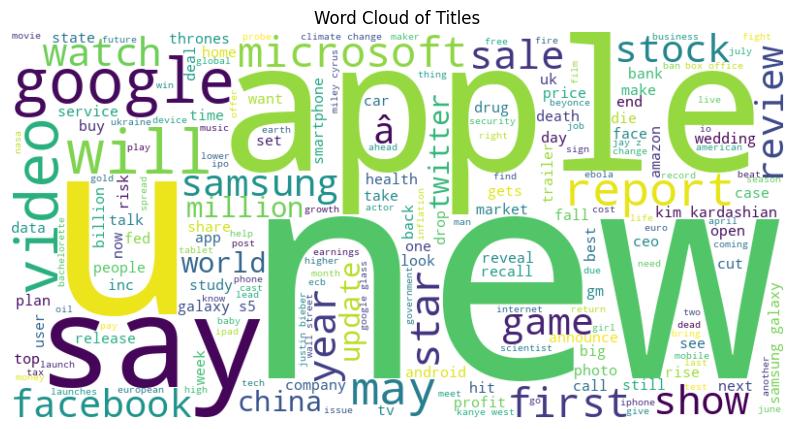

In [39]:
# Word Cloud Visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['clean_title']))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Titles')
plt.show()

**h. Distribution of Articles by Publisher & Category**

The **visualization of the distribution of articles by publisher** is essential for understanding the representation of different publishers in the dataset. By plotting the top 20 publishers with the highest article counts, we can identify which publishers are most prominent. The bar chart effectively conveys this information, with the 'teal' color chosen for better visual distinction. Rotating the x-axis labels helps in reading the publisher names clearly, especially if they are long.

**Replacing category abbreviations with more descriptive names** improves the clarity of the data. It makes the categories more interpretable and ensures that the visualizations are more informative for users who may not be familiar with the abbreviations.

The **distribution of articles by category** is then visualized to show the proportion of articles within each category. The bar chart, with 'coral' color, helps in understanding how articles are distributed across different categories. Rotating the x-axis labels enhances readability, making it easier to interpret the chart. This visualization provides insights into the focus areas of the articles, indicating which categories are more prevalent in the dataset.

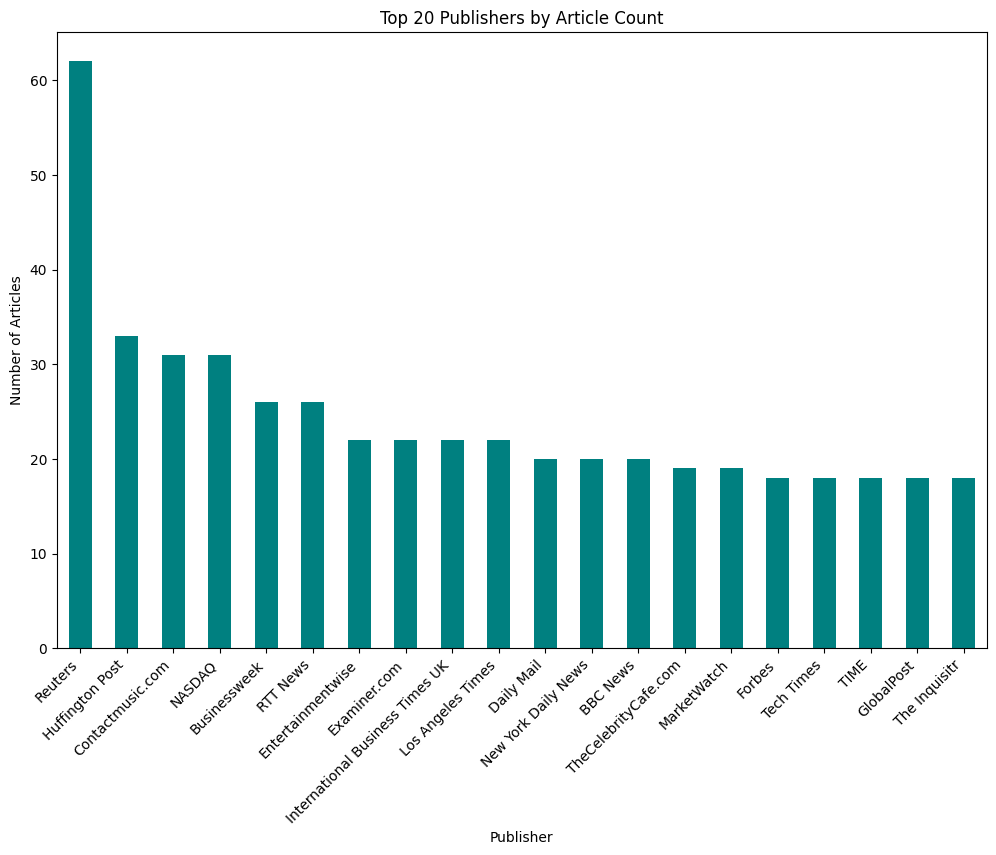

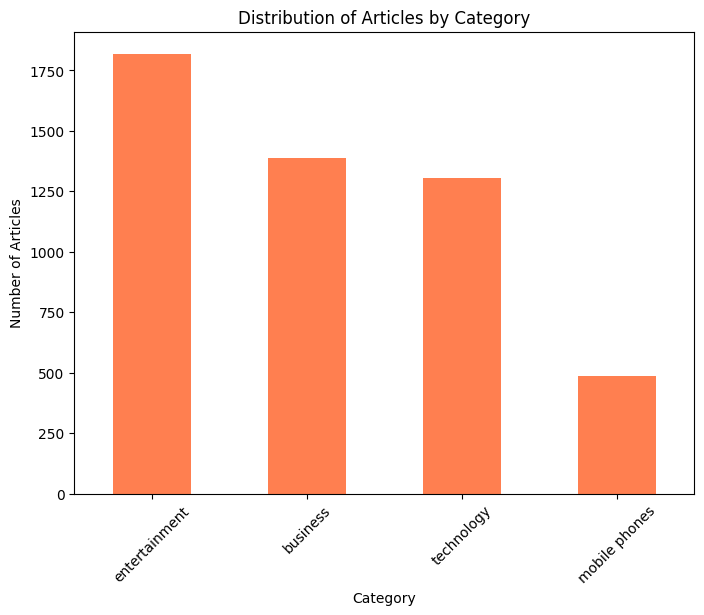

In [40]:
# Distribution of articles by publisher
plt.figure(figsize=(12, 8))
df['PUBLISHER'].value_counts().head(20).plot(kind='bar', color='teal')
plt.title('Top 20 Publishers by Article Count')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.show()

# Replacing Categories by relevant names for better visual interpretation
df['CATEGORY'] = df['CATEGORY'].replace('e', 'entertainment')
df['CATEGORY'] = df['CATEGORY'].replace('b', 'business')
df['CATEGORY'] = df['CATEGORY'].replace('m', 'mobile phones')
df['CATEGORY'] = df['CATEGORY'].replace('t', 'technology')

# Distribution of articles by category
plt.figure(figsize=(8, 6))
df['CATEGORY'].value_counts().plot(kind='bar', color='coral')
plt.title('Distribution of Articles by Category')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

**i. Time based Analysis**

The timestamp conversion and time-based analysis are crucial for understanding temporal trends in the dataset.

First, scientific notation in the 'TIMESTAMP' column is converted to integers to standardize the data format. This step ensures that timestamps are handled as whole numbers, facilitating further processing.

Next, the integer timestamps are converted to datetime format, assuming they represent milliseconds. This conversion is essential for performing time-based analyses.

If the 'TIMESTAMP' column exists, it's further processed to extract day and month information. The presence of 'TIMESTAMP' indicates that time-based patterns can be explored.

Two plots are generated:
- The number of articles per day is visualized with a line plot, showing how article counts vary over days within a year. This can reveal daily trends or patterns.
- The number of articles per month is also visualized with a line plot, providing insights into monthly trends. This helps in understanding seasonal variations or periodic patterns.

The grid and markers in the plots enhance readability and highlight data points, making temporal patterns easier to interpret. If the 'TIMESTAMP' data is not available or relevant, a message is printed to indicate this, avoiding unnecessary analysis.

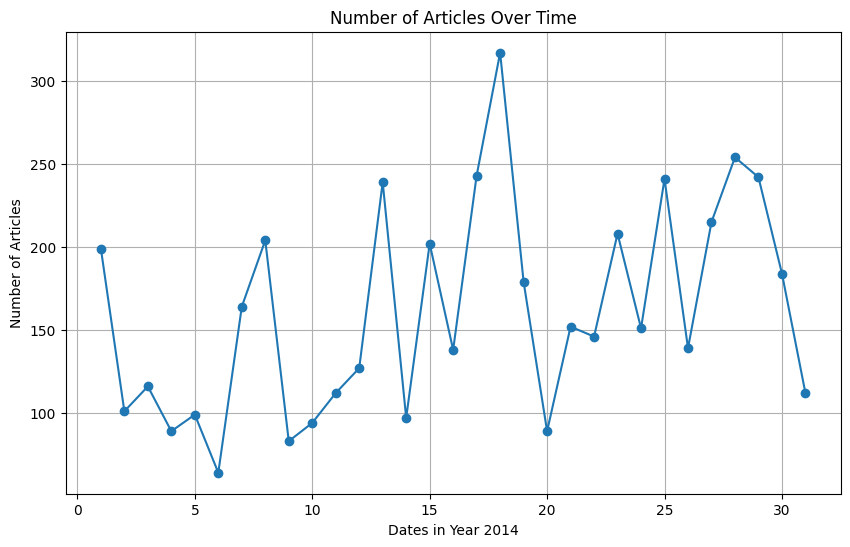

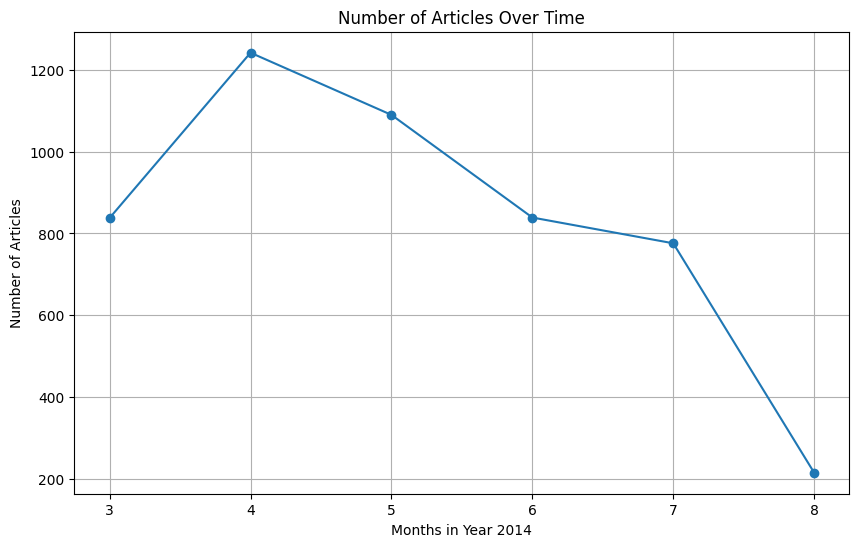

In [41]:
# Convert scientific notation to integer
df['TIMESTAMP'] = df['TIMESTAMP'].astype(float).astype(int)

# Convert integer timestamp to datetime (assuming milliseconds)
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], unit='ms')

# Time-based analysis (if timestamp is available and relevant)
if 'TIMESTAMP' in df.columns:
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], unit='s', errors='coerce')
    df['Day'] = df['TIMESTAMP'].dt.day
    df['Month'] = df['TIMESTAMP'].dt.month

    # Plotting the number of articles over time in days
    plt.figure(figsize=(10, 6))
    df['Day'].value_counts().sort_index().plot(kind='line', marker='o')
    plt.title('Number of Articles Over Time')
    plt.xlabel('Dates in Year 2014')
    plt.ylabel('Number of Articles')
    plt.grid(True)
    plt.show()

    # Plotting the number of articles over time in months
    plt.figure(figsize=(10, 6))
    df['Month'].value_counts().sort_index().plot(kind='line', marker='o')
    plt.title('Number of Articles Over Time')
    plt.xlabel('Months in Year 2014')
    plt.ylabel('Number of Articles')
    plt.grid(True)
    plt.show()
else:
    print("\n### Timestamp Data Not Available or Relevant for Analysis ###")

**j. Correlation Analysis**

The correlation analysis aims to identify relationships between numeric features in the dataset.

First, numeric columns are selected using df.select_dtypes(include=[np.number]), which isolates only the numerical features from the dataset. This is important because correlation analysis is only meaningful for numerical data.

If there is more than one numeric column, a heatmap of the correlation matrix is generated using seaborn's sns.heatmap(). The correlation matrix shows the strength and direction of linear relationships between the numeric features, with values ranging from -1 to 1. Positive correlations (close to 1) indicate that as one feature increases, so does the other, while negative correlations (close to -1) suggest an inverse relationship. The coolwarm color map visually highlights strong positive and negative correlations.

If there are insufficient numeric features for analysis (i.e., fewer than two numeric columns), a message is printed to indicate that correlation analysis is not applicable. This ensures that the analysis is only performed when meaningful and avoids unnecessary computation or interpretation of non-numeric data.

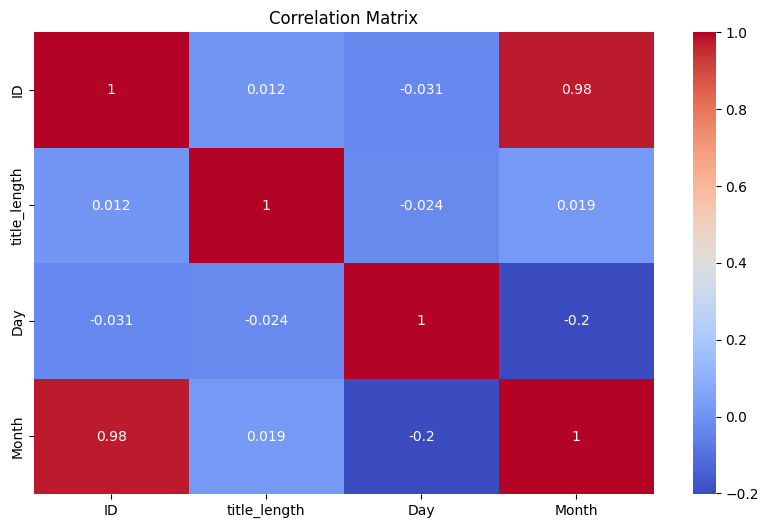

In [42]:
# Correlation analysis (if numeric features exist)
numeric_cols = df.select_dtypes(include=[np.number])
if numeric_cols.shape[1] > 1:
    plt.figure(figsize=(10, 6))
    sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()
else:
    print("\n### No Sufficient Numeric Features for Correlation Analysis ###")

**k. Lemmatization and Vectorization**

**Lemmatization**:
Lemmatization is a text preprocessing step that reduces words to their base or root form. This process is performed using the WordNetLemmatizer from the NLTK library. Lemmatization is preferred over stemming as it returns a valid word form, ensuring better semantic meaning. It helps in grouping different forms of a word (e.g., "running" and "ran") into a single form ("run"), which improves the consistency and quality of the text data for analysis. The preprocess() function applies lemmatization to tokens after filtering out stop words and non-alphanumeric characters, resulting in a more meaningful representation of the text.

**Vectorization**:
Vectorization converts text data into numerical format suitable for machine learning models. The CountVectorizer from scikit-learn is used to create a bag-of-words (BoW) representation of the preprocessed text. This method generates a document-term matrix where each row represents a document (or title), and each column corresponds to a unique word in the corpus. The max_df parameter excludes words that appear in more than 95% of the documents, while min_df excludes words that appear in fewer than 2 documents. This filtering helps in focusing on more relevant words and excluding those that are too common or too rare. The resulting matrix (X) captures the frequency of each word in the text data, enabling the use of various text analysis techniques and models.

In [43]:
# Preprocessing steps: tokenization, stop word removal, lemmatization
lemmatizer = WordNetLemmatizer()
token_array=[]

def preprocess(text):
    # Tokenize, remove stop words, and lemmatize
    tokens = word_tokenize(text.lower())
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    token_array = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_tokens)

# Apply preprocessing to the 'TITLE' column
df['preprocessed_text'] = df['filtered_text'].apply(preprocess)

# Vectorize the cleaned titles using CountVectorizer (BoW)
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['preprocessed_text'])

# 2. LDA Algorithm to Create Min 10 Topics

LDA (Latent Dirichlet Allocation) is used to extract latent topics from text data, with n_components=10 specifying the number of topics and random_state=42 ensuring reproducibility. After fitting the model to the document-term matrix, the display_topics function is employed to print the top words for each topic. It does this by sorting the words in each topic based on their relevance, displaying the most important ones using the feature names from the vectorizer. Word clouds are then used for visualizing these top words, providing an intuitive, visual representation of the topics. Each word cloud highlights the most relevant words for each topic, making it easier to interpret the results.


Topic 1:
twitter | american | earnings | cut | live | new | 2014 | season | throne | game
Topic 2:
dancing | week | future | court | wall | day | street | market | star | stock
Topic 3:
jay | new | facebook | 2014 | rise | award | year | bank | profit | rate
Topic 4:
video | justin | bieber | android | s5 | gm | new | recall | samsung | galaxy
Topic 5:
people | cost | amazon | woman | met | video | apple | year | ipad | music
Topic 6:
star | euro | right | america | dollar | buy | store | day | glass | google
Topic 7:
change | bug | chris | heartbleed | china | data | office | window | box | report
Topic 8:
lohan | lindsay | miley | twitter | cyrus | study | war | star | say | new
Topic 9:
price | space | ebola | samsung | say | sale | trailer | home | apple | new
Topic 10:
gold | climate | ebola | men | dead | wedding | kanye | west | kardashian | kim


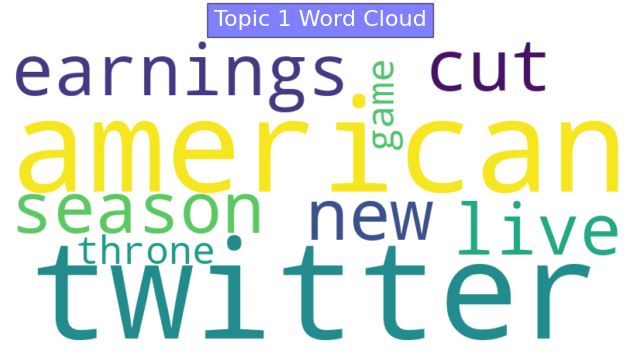

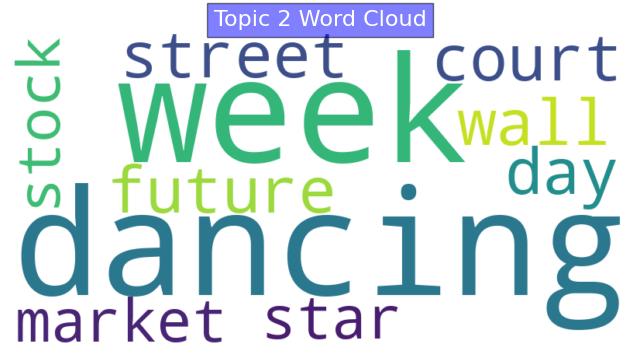

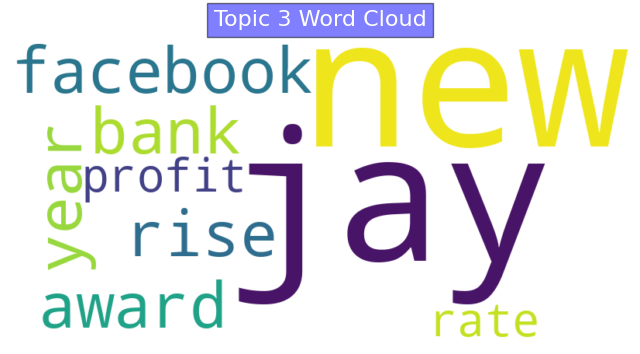

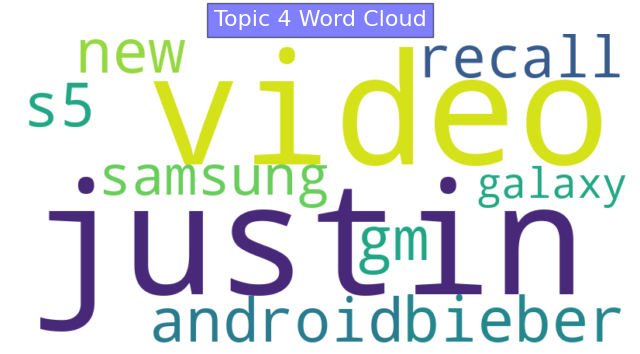

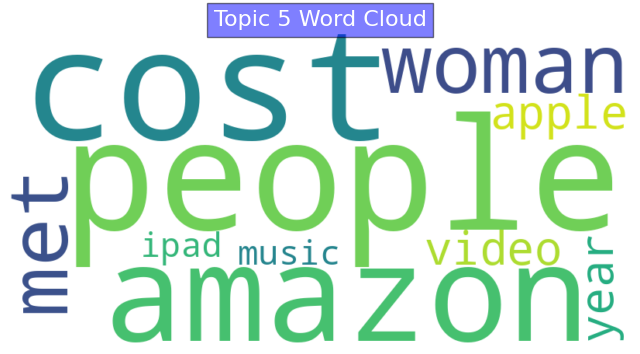

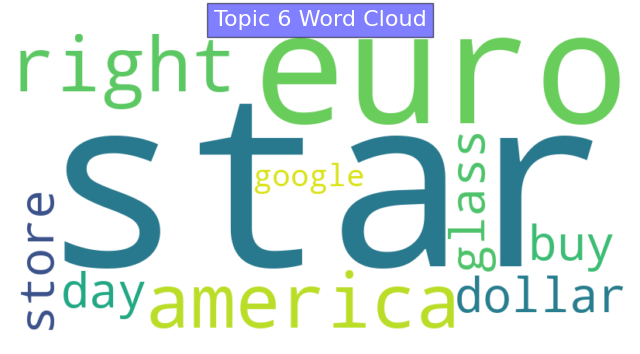

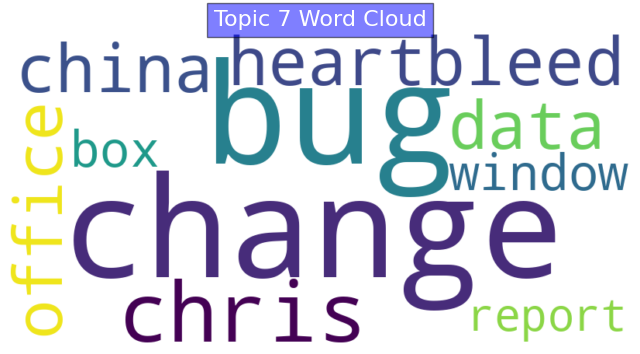

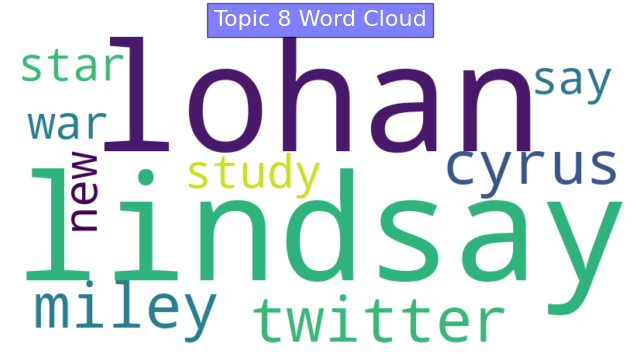

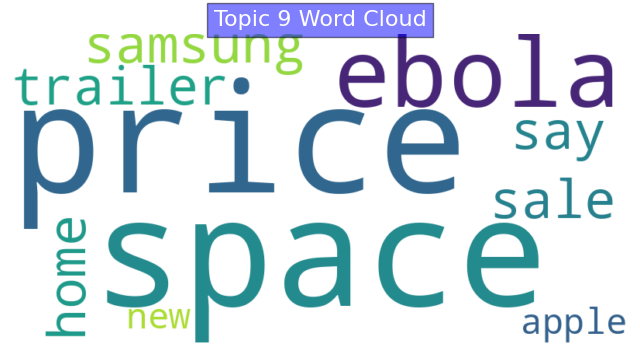

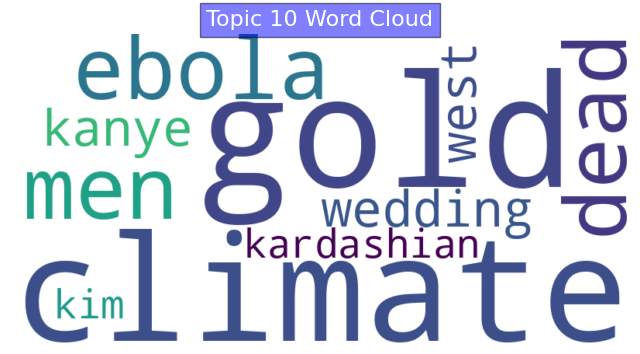

In [44]:
# Fit LDA model
lda = LDA(n_components=10, random_state=42)  # Adjust the number of topics as needed
lda.fit(X)

# Display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx + 1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[-no_top_words:]]))

# Show the top words for each topic
no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

# Visualizing topics using Word Cloud
for idx, topic in enumerate(lda.components_):
    plt.figure(figsize=(8, 6))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-no_top_words:]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {idx + 1} Word Cloud', fontsize=16, color='white',
              bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 5})
    plt.show()

# 3. Coherence Score Computation

The preprocess_text function performs text preprocessing by tokenizing the text, converting it to lowercase, removing punctuation, and lemmatizing the tokens, while filtering out stop words. This ensures the input data is clean and standardized for topic modeling. The preprocessed text is applied to the dataset using df['processed_text'] = df['filtered_text'].apply(preprocess_text). Next, the dictionary and corpus are created for the LDA model. The dictionary maps words to unique IDs, and the corpus represents each document as a bag-of-words model. The gensim LDA model is built with 10 topics (num_topics=10), using parameters such as random_state=42 for reproducibility, passes=10 for multiple iterations over the corpus, and alpha='auto' for automatic adjustment of topic distribution. The topics are printed using lda_model.print_topics(), displaying the top 10 words for each topic. Lastly, the coherence score is calculated using the CoherenceModel to evaluate the model's consistency and interpretability, with the coherence score indicating how well the topics make sense.


In [45]:
# Text Preprocessing
def preprocess_text(text):
     # Tokenize and remove punctuation
     tokens = word_tokenize(text.lower())
     tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
     return tokens

 # Applying preprocessing
df['processed_text'] = df['filtered_text'].apply(preprocess_text)

# Create Dictionary and Corpus for LDA
dictionary = corpora.Dictionary(df['processed_text'])
corpus = [dictionary.doc2bow(text) for text in df['processed_text']]

# Build LDA Model
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=10,
                                   random_state=42,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha='auto',
                                   per_word_topics=True)

# Print the topics
print("### Topics Extracted by LDA Model ###")
topics = lda_model.print_topics(num_words=10)
for idx, topic in topics:
    print(f"Topic {idx+1}: {topic}")

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['processed_text'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(f"\n### Coherence Score ###\nCoherence Score: {coherence_score:.4f}")

### Topics Extracted by LDA Model ###
Topic 1: 0.024*"show" + 0.021*"game" + 0.020*"year" + 0.018*"world" + 0.017*"china" + 0.015*"make" + 0.015*"share" + 0.015*"amazon" + 0.012*"music" + 0.012*"oil"
Topic 2: 0.016*"buy" + 0.015*"billion" + 0.011*"kim" + 0.011*"justin" + 0.011*"health" + 0.010*"business" + 0.009*"met" + 0.009*"profit" + 0.009*"kardashian" + 0.009*"face"
Topic 3: 0.022*"woman" + 0.019*"next" + 0.018*"people" + 0.012*"fact" + 0.012*"water" + 0.011*"cover" + 0.011*"quick" + 0.010*"negative" + 0.010*"brad" + 0.010*"pregnant"
Topic 4: 0.030*"first" + 0.020*"rate" + 0.018*"time" + 0.015*"bank" + 0.014*"dollar" + 0.013*"drop" + 0.013*"ipad" + 0.011*"higher" + 0.011*"android" + 0.010*"return"
Topic 5: 0.048*"say" + 0.026*"data" + 0.025*"â" + 0.024*"study" + 0.020*"hit" + 0.015*"market" + 0.013*"rise" + 0.013*"call" + 0.011*"cause" + 0.010*"ukraine"
Topic 6: 0.051*"google" + 0.026*"million" + 0.026*"get" + 0.019*"back" + 0.018*"fall" + 0.015*"look" + 0.014*"glass" + 0.013*"film

# 4. Topic Visualization

The plot_wordcloud function is designed to visualize the top words for each topic using word clouds, where the size of each word reflects its importance in the topic. The function generates a word cloud using the generate_from_frequencies method, which takes a dictionary of words and their corresponding weights (importance). The figure is displayed using matplotlib with plt.imshow(), and plt.axis('off') removes axis labels for a cleaner visual. In the loop, lda_model.print_topics(num_words=50) extracts the top 50 words and their weights for each topic, and the words are processed into a dictionary of word-weight pairs. The plot_wordcloud function is called for each topic, creating a word cloud that visually represents the most important words for that topic. This allows for easy interpretation of the LDA results.


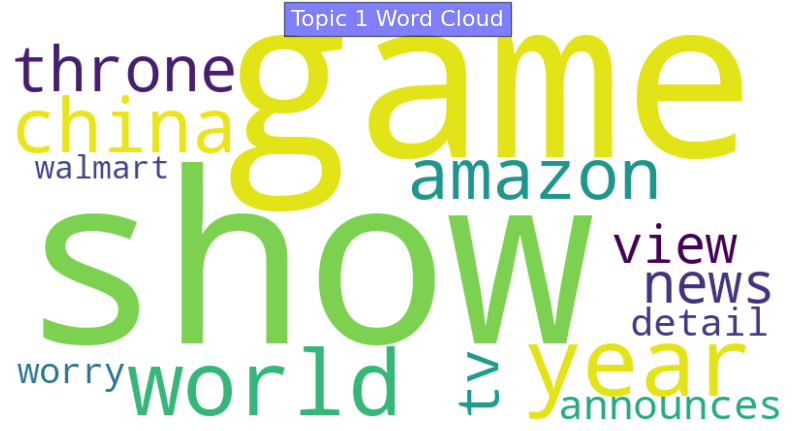

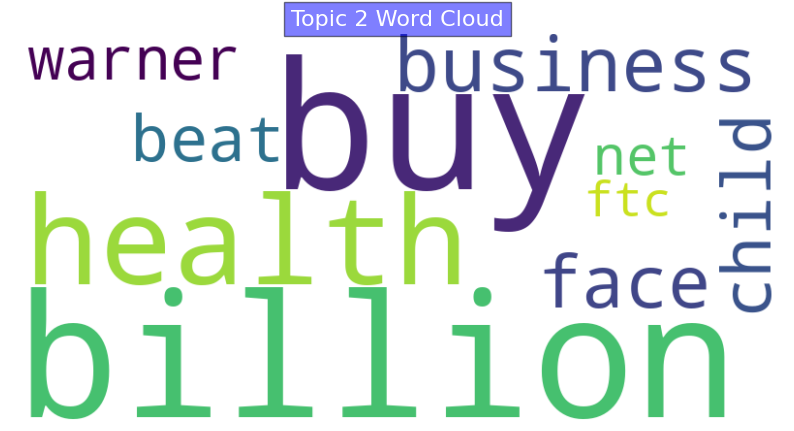

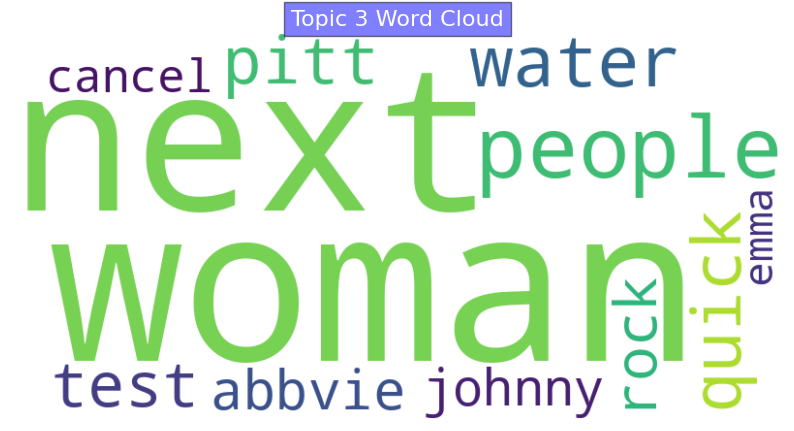

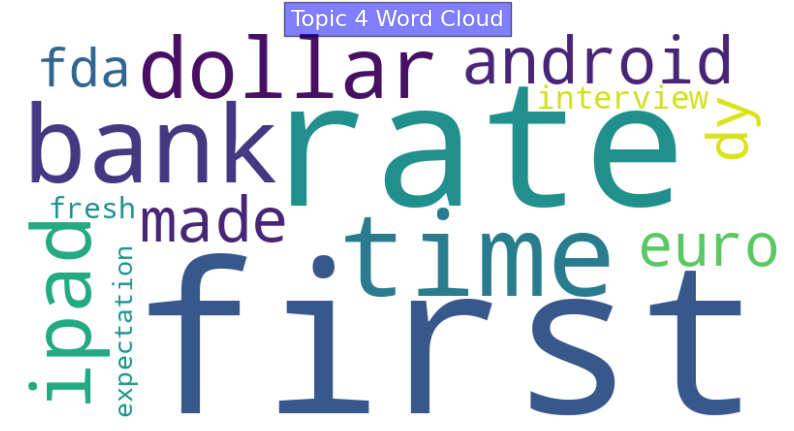

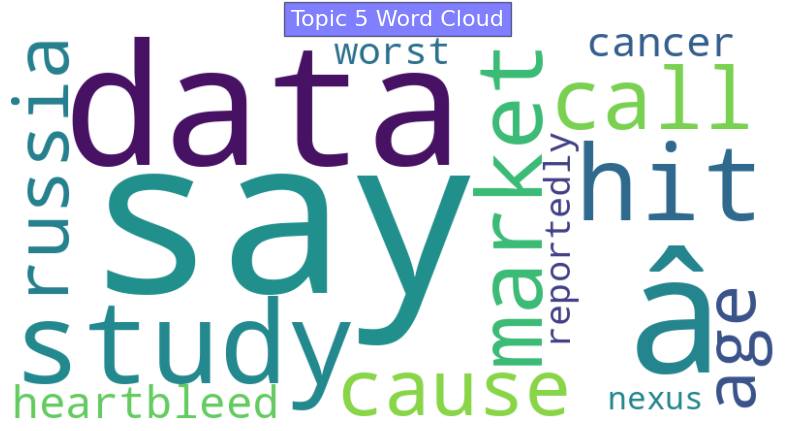

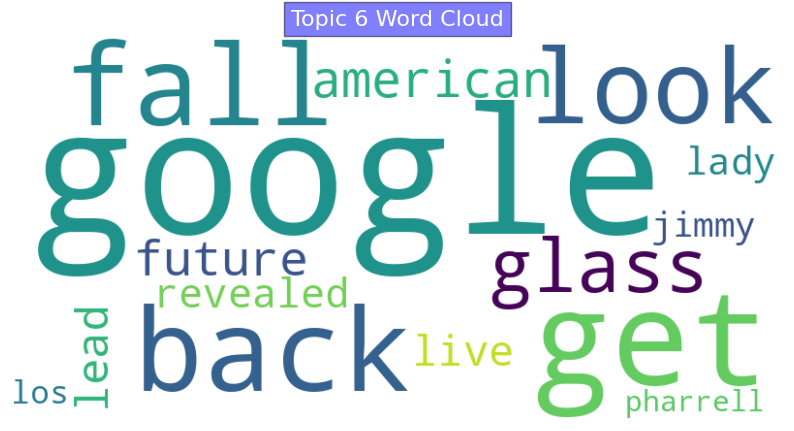

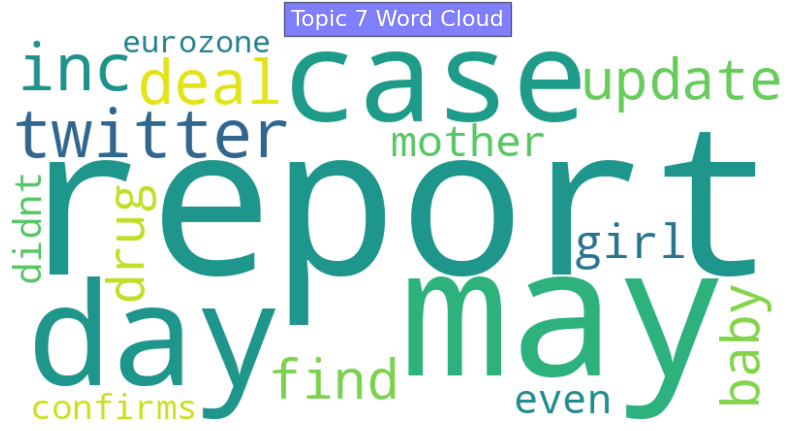

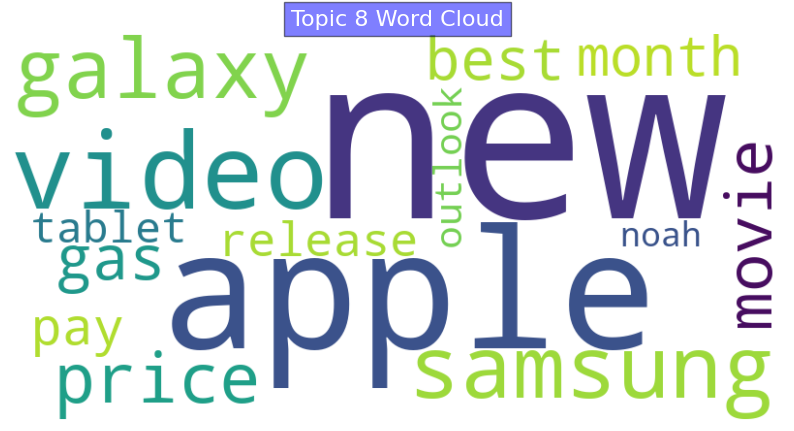

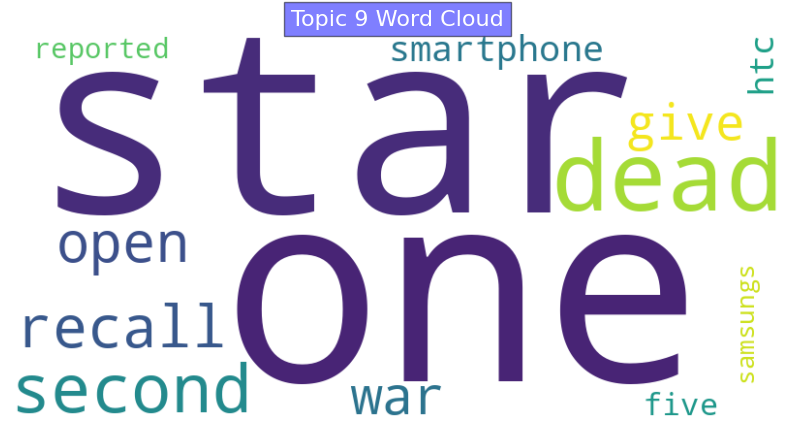

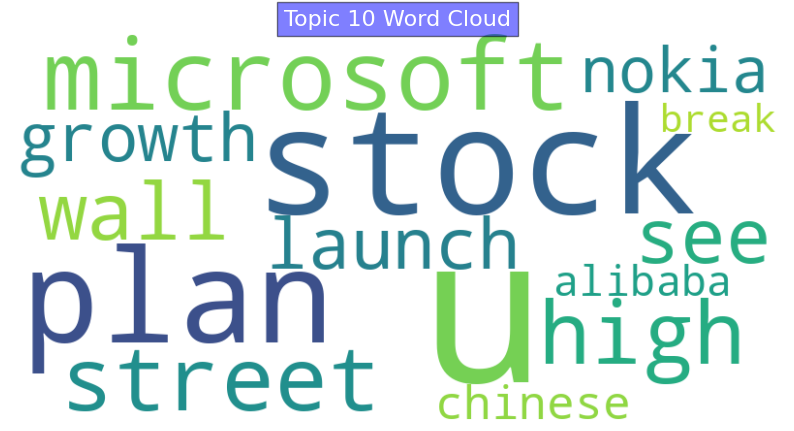

In [46]:
def plot_wordcloud(topic_words, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16, color='white',
              bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 5})
    plt.axis('off')
    plt.show()

# Extract words for each topic and visualize
for idx, topic in lda_model.print_topics(num_words=50):  # Adjust the number of words if needed
    topic_words = dict([tuple(word.split('*"')) for word in topic.split(' + ')])
    topic_words = {word.rstrip('"'): float(weight) for weight, word in topic_words.items()}
    plot_wordcloud(topic_words, f'Topic {idx+1} Word Cloud')

**a. Interactive HTML for Topic Visualization**

The pyLDAvis.gensim_models.prepare function is used to prepare the data for interactive visualization of the LDA model. It takes the trained LDA model, the corpus (bag-of-words representation of the documents), and the dictionary (mapping of word IDs to actual words) as input. This function generates an interactive HTML visualization that allows for exploration of the topics, the distribution of words across topics, and the relationships between topics. The pyLDAvis.save_html function then saves the visualization as an HTML file, making it easy to share and analyze. The visualization provides a dynamic way to inspect the LDA model’s performance and gain insights into the topic distributions and word relevance within the dataset.


In [47]:
# Prepare the visualization data
vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

# Save the visualization to an HTML file
pyLDAvis.save_html(vis_data, 'lda_visualization.html')

print("LDA visualization saved to 'lda_visualization.html'.")

LDA visualization saved to 'lda_visualization.html'.


# 5. Dependency Parser Plot

The spaCy library is used here for natural language processing tasks, particularly to analyze the syntactic structure of sentences. The function get_long_sentences filters sentences from a specified column in the dataframe, selecting only those with at least 10 words to ensure meaningful content for analysis. The long_sentences list is created by filtering the sentences, and random.sample is used to select two sentences randomly for visualization. Each sentence is processed using spaCy's nlp model (here 'en_core_web_sm'), which tokenizes the sentence and applies linguistic annotations such as part-of-speech tags and dependency parsing. The displacy.render function is then used to generate an interactive visualization of the syntactic dependencies in the sentence, displayed in the Jupyter environment with the jupyter=True argument. The display of dependency parses provides a clear and intuitive representation of the grammatical structure, helping in understanding the relationships between words in each sentence.


In [48]:
from IPython.display import display, HTML

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to select sentences with at least 10 words
def get_long_sentences(df, column='TITLE', min_length=10):
    long_sentences = df[df[column].str.split().str.len() >= min_length][column].tolist()
    return long_sentences

# Get long sentences
long_sentences = get_long_sentences(df)

# Select two random sentences
random_sentences = random.sample(long_sentences, 2)

# Process and visualize the sentences
for sentence in random_sentences:
    doc = nlp(sentence)

    # Plot dependency parse
    plt.figure(figsize=(12, 8))
    display(HTML(f'<h2 style="font-size:24px;">Dependency Parse for: "{sentence}"</h2>'))
    displacy.render(doc, style='dep', jupyter=True)

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>